Importing Libraries

In [1]:
import matplotlib.pyplot as plt
from scipy.io import loadmat
from mpl_toolkits.mplot3d import Axes3D
from scipy.ndimage.morphology import binary_closing
from scipy.ndimage.morphology import binary_opening
import numpy as np
import cv2

/var/folders/mm/zm2c4z0n06b2tq4zt0hs6sfc0000gn/T/ipykernel_97333/1796674642.py:4: DeprecationWarning: Please use `binary_closing` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  from scipy.ndimage.morphology import binary_closing
/var/folders/mm/zm2c4z0n06b2tq4zt0hs6sfc0000gn/T/ipykernel_97333/1796674642.py:5: DeprecationWarning: Please use `binary_opening` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  from scipy.ndimage.morphology import binary_opening


Loading the data

In [18]:
# mat = loadmat('data/example1kinect.mat',  mdict=None, appendmat=True)
# mat = loadmat('data/example2kinect.mat',  mdict=None, appendmat=True)
mat = loadmat('data/example3kinect.mat',  mdict=None, appendmat=True)
# mat = loadmat('data/example4kinect.mat',  mdict=None, appendmat=True)
# mat = loadmat('data/example4kinect_corrected.mat',  mdict=None, appendmat=True)
print(mat.keys())
keys = list(mat.keys())

dict_keys(['__header__', '__version__', '__globals__', 'amplitudes3', 'distances3', 'cloud3'])


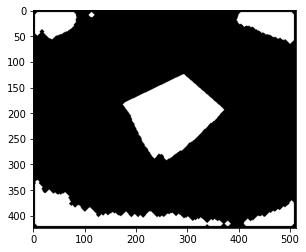

In [19]:
amplitude = mat[keys[3]]
normalized_image = cv2.normalize(amplitude, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)

ret,thresh1 = cv2.threshold(normalized_image,23,255,cv2.THRESH_BINARY)
plt.imshow(thresh1, cmap='gray')
closed_image = binary_closing(thresh1, iterations=4)
plt.imshow(closed_image, cmap='gray')
opened_image = binary_opening(closed_image, iterations=4)
plt.imshow(opened_image, cmap='gray')

Showing amplitude image

In [ ]:
amplitude = mat[keys[3]]
plt.imshow(amplitude)

Showing distance image

In [ ]:
distance = mat[keys[4]]
plt.imshow(distance)

Showing cloud image

In [ ]:
cloud = mat[keys[5]]
# plt.imshow(cloud)

3D plot of Point Cloud

In [ ]:
num_rows, num_cols, num_xyz = cloud.shape

# Reshape the cloud values array to flatten the (x, y, z) coordinates
cloud_values_flat = cloud.reshape((num_rows * num_cols, num_xyz))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the points
ax.scatter(cloud_values_flat[:, 0], cloud_values_flat[:, 1], cloud_values_flat[:, 2], zdir='z')

plt.show()